In [73]:
# -*- coding:utf-8 -*-
import json
import requests
import csv,re,os,math,glob
from lxml import etree
from datetime import date,datetime
import pandas as pd
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import hashlib #check md5sum of rawdata files

In [2]:
#Save_interest_rate

In [3]:
def save_interest_rate(data):
    
    # 1. 创建文件对象
    f = open('CB_interest_rate.csv', 'w', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    # 3. 构建列表头
    csv_writer.writerow(["id","iry1", "iry2", "iry3", "iry4", "iry5", "iry6"])
    
    count = 0
    for item in data:
        count +=1
        if (count %10 == 0):
            print("processing "+str(count)+" items")
        try:
            interest = get_interest_rate(item['id'])
            interest = [item['id']]+interest
            csv_writer.writerow(interest)
        except Exception as e:
            print("Oops!", e.__class__, "occurred.")
            print("The error happed at "+item['id'])
    # 5. 关闭文件
    print("Finished processing "+str(count)+" items")
    f.close()


In [4]:
#append_interest_rate

In [5]:
def append_interest_rate(item):
    
    # 1. 创建文件对象
    interest_dict = get_interest_dict('CB_interest_rate.csv')
    if item['id'] in interest_dict:
        return
    f = open('CB_interest_rate.csv', 'a', encoding='utf-8', newline='')
    # 2. 基于文件对象构建 csv写入对象
    csv_writer = csv.writer(f)
    
    

    try:
        interest = get_interest_rate(item['id'])
        interest = [item['id']]+interest
        csv_writer.writerow(interest)
        print("Finished appending new CB "+ item['name']+" into interest rate files")
    except Exception as e:
        print("Oops!", e.__class__, "occurred.")
        print("The error happed at "+item['id'])
    
    # 5. 关闭文件
    
    f.close()


In [6]:
#get_interest_rate

In [101]:
def get_interest_rate(id):
    years = 6
    detials_url = 'https://www.jisilu.cn/data/convert_bond_detail/'+id
    detials_response = requests.get(detials_url)
    html = detials_response.content.decode("utf-8")
    html = etree.HTML(html)
    interest_text = html.xpath('.//td[@id="cpn_desc"]/text()')
    if(not interest_text[0].find('%')):
        print(" not in interest test %s %s"%(id,interest_text))
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?')  #get proper format number
    else:
        pattern = re.compile(r'(?<!\d|\.)\d+(?:\.\d+)?\s?%')  #get proper format number
    interest = pattern.findall(interest_text[0])
    if(len(interest) <= 1):
        print("%s fixed interest rate %s"%(id, interest_text[0]))
        interest = interest*years
    elif(len(interest)<5):
        print("%s number of interest rate between 2-4 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    elif(len(interest)>6):
        print("%s number of interest rate greater than 6 %s"%(id, interest_text[0]))
        print("You may need to check manually")
    interest = [rate.strip("%") for rate in interest]
    return interest

In [8]:
# get interest dict

In [9]:
def get_interest_dict(file):
    interest_dict = dict()
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                #skip header
                line_count += 1
            else:
                interest_dict[row[0]] = row[1:]
                line_count += 1
        print(f'Processed {line_count} lines.')
    return interest_dict


In [10]:
# buy or sell cb

In [11]:
def buy_sell_db(db_df,file,show_price=False):
    total_number = len(db_df)
    quartile = np.percentile(db_df['db_low'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:db_df['name'][i] for i in db_df[0:keep_number].index}
    buy_dict = {i:db_df['name'][i] for i in db_df[0:buy_number].index}
    add_dict = {i:db_df['name'][i] for i in db_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,category = row
            if cb_id not in db_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                continue
            holding_dict[cb_id] = cb_name
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low}
            my_list.append(item)
            if('db' not in category):
                continue
            if cb_id not in keep_dict.keys():
                sell = "Sell"
                if(db_low>quartile):
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f"%(sell,cb_id,cb_name,price,db_low))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = db_df.loc[cb_id]['price']
        db_low = db_df.loc[cb_id]['db_low']
        if(show_price):
            print("Add  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id in buy_dict.keys():
        if cb_id not in holding_dict.keys():
            price = db_df.loc[cb_id]['price']
            db_low = db_df.loc[cb_id]['db_low']
            cb_name = keep_dict[cb_id]
            if(show_price):
                print("Buy  %s %s %s %.3f"%(cb_id,cb_name,price,db_low))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    my_df = pd.DataFrame(my_list)
    my_df = my_df.set_index(['id'])
    my_df = my_df.sort_values('db_low',ascending=True)
    return my_df,buy_dict
    

In [12]:
#buy sell low

In [52]:
def buy_sell_low(lp_df,db_buy_dict,file,show_price=False):
    total_number = len(lp_df)
    quartile = np.percentile(lp_df['lower_deviation'],25) ##first quartile
    keep_number = int(total_number*0.1)  ##10th percentile
    buy_number  = int(total_number*0.05) ##5th percentile
    add_number = int(total_number*0.02)  ##2th percentile
    
    keep_dict = {i:lp_df['name'][i] for i in lp_df[0:keep_number].index}
    buy_dict = {i:lp_df['name'][i] for i in lp_df[0:buy_number].index}
    add_dict = {i:lp_df['name'][i] for i in lp_df[0:add_number].index}
    sell_count = 0
    holding_dict = dict()
    
    ##sell
    my_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            cb_id,cb_name,category = row
            if cb_id not in lp_df.index:
                print("%s %s %s"%(cb_id,cb_name,'not in lists'))
                sell_count += 1
                continue
            holding_dict[cb_id] = cb_name
            price = lp_df.loc[cb_id]['price']
            db_low  = lp_df.loc[cb_id]['db_low']
            premium = lp_df.loc[cb_id]['premium']
            lower_deviation = lp_df.loc[cb_id]['lower_deviation']
            fit_price = lp_df.loc[cb_id]['fit_price']
            low_fit_price = lp_df.loc[cb_id]['low_fit_price']
            upper_fit_price = lp_df.loc[cb_id]['upper_fit_price']
            item = {'id':cb_id,'name':cb_name,'price':price,'db_low':db_low,'premium':premium,
                    'lower_deviation':lower_deviation}
            my_list.append(item)
            if cb_id not in keep_dict.keys() or price>fit_price:
                if('db' in category and price<fit_price):
                    continue
                sell = "Sell"
                if(lower_deviation>quartile or price>upper_fit_price):
                    if('db' in category and price<upper_fit_price):
                        continue
                    sell = "Strong Sell"
                if(show_price):
                    print("%s %s %s %s %.3f %.3f %.3f"
                          %(sell,cb_id,cb_name,price,db_low,premium,lower_deviation))
                else:
                    print("%s %s %s"%(sell,cb_id,cb_name))
                sell_count += 1
    if(sell_count==0):
        print('No CB to sell')
        
    ##buy
    print()
    for cb_id,cb_name in add_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if price>=low_fit_price:
            continue
        if(show_price):
            print("Add  %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        else:
            print("Add  %s %s"%(cb_id,cb_name))
    print()
    for cb_id,cb_name in buy_dict.items():
        price = lp_df.loc[cb_id]['price']
        db_low  = lp_df.loc[cb_id]['db_low']
        premium = lp_df.loc[cb_id]['premium']
        lower_deviation = lp_df.loc[cb_id]['lower_deviation']
        low_fit_price = lp_df.loc[cb_id]['low_fit_price']
        if cb_id in db_buy_dict.keys():
            print("Strong Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
        elif cb_id not in holding_dict.keys():
            if price>=low_fit_price:
                continue
            
            if(show_price):
                print("Buy %s %s %s %.3f %.3f %.3f"
                  %(cb_id,cb_name,price,db_low,premium,lower_deviation))
            else:
                print("Buy  %s %s"%(cb_id,cb_name))
    
    #my_df = pd.DataFrame(my_list)
    #my_df = my_df.set_index(['id'])
    #my_df = my_df.sort_values('premium',ascending=True)
    #return my_df
    

In [14]:
# read historical data

In [15]:
def read_historical_data(file):
    history_list = []
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader, None)  # skip the headers
        for row in csv_reader:
            history_list.append(row)
    return history_list

In [16]:
# get data

In [56]:
def get_dat():
    # Fill in your details here to be posted to the login form.
    payload = {
        'user_name': 'a39856ed4377d1b92cffb0677febf5b8',
        'password': 'ca5572b5ffe8c33746727709bc7d6c6f'
    }
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36",
        #"User-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.106 Safari/537.36 OPR/38.0.2220.41",
        "Cookie": "kbzw__Session=l313fggdcjpnd7eineqilm6lf4; kbz_newcookie=1; kbzw_r_uname=ijayden; Hm_lvt_164fe01b1433a19b507595a43bf58262=1627073048,1627079966,1627115858,1627117055; Hm_lpvt_164fe01b1433a19b507595a43bf58262=1627118717"
    }
    loginUrl="https://www.jisilu.cn/account/ajax/login_process/"
    r = requests.post(loginUrl,data=payload)

    newUrl ="https://www.jisilu.cn/data/cbnew/cb_list/?___jsl=LST___t=1584777951900"
    #最简单的爬虫请求.也可以加上headers字段，防止部分网址的反爬虫机制
    response = requests.get(newUrl,cookies=r.cookies)
    data = response.content.decode("utf-8")
    dat = json.loads(data)

    # 所有数据
    lst_data = []
    count = 0
    for one in dat['rows']:
        # 每一条数据
        lst_dat = dict()
        # 转债id
        id = one["id"]
        dat_cell = one["cell"]
        # 是否赎回
        is_force_redeem = dat_cell['redeem_flag']
        is_list = dat_cell['price_tips']
        
        if is_list != "待上市":
            
            count += 1
            if (count %100 == 0):
                print("processing "+str(count)+" items")
            
            # 转债名称
            name = dat_cell['bond_nm']
            # 现价
            price = dat_cell['price']
            # stock id
            stock_id = dat_cell['stock_id']
            stock_id = stock_id.replace("sh", "ss")
            stock_id = stock_id[2:]+"."+stock_id[0:2]
            # stock name
            stock_nm = dat_cell['stock_nm']
            # 溢价率
            premium_rt = dat_cell['premium_rt']
            # 评级
            rating_cd = dat_cell['rating_cd']
            
            
            # next put date
            next_put_dt = dat_cell['next_put_dt']
            # put price
            put_price   = dat_cell['put_price']
            # 回售触发价
            put_convert_price = dat_cell['put_convert_price']
            
            
            # maturity date
            maturity_dt = dat_cell['maturity_dt']
            # redeem price
            redeem_price = dat_cell['redeem_price']
            
            # 强赎触发价
            redeem_dt = dat_cell['redeem_dt']
            force_redeem_price = dat_cell['force_redeem_price']
            # 剩余时间
            last_time = dat_cell['year_left']
            pb = dat_cell['pb']


            #lst_dat.append(id)
            lst_dat['id'] = id
            lst_dat['name'] = name
            lst_dat['stock_id'] = stock_id
            lst_dat['stock_name'] = stock_nm
            lst_dat['price'] = float(price)
            lst_dat['convert_value'] = float(dat_cell['convert_value'])
            lst_dat['premium_rt'] = premium_rt
            lst_dat['rating_cd'] = rating_cd
            lst_dat['pb']  = pb
            lst_dat['convert_amt_ratio'] = dat_cell['convert_amt_ratio']
            lst_dat['convert_amt_ratio2'] = dat_cell['convert_amt_ratio2']
            
            
            
            lst_dat['next_put_dt'] = next_put_dt
            lst_dat['put_price'] = put_price
            lst_dat['put_convert_price'] = put_convert_price
            
            lst_dat['maturity_dt'] = maturity_dt
            lst_dat['redeem_price'] = redeem_price
            lst_dat['last_time'] = last_time
            lst_dat['force_redeem'] = is_force_redeem
            
            lst_dat['redeem_dt']  = redeem_dt
            lst_dat['force_redeem_price'] = force_redeem_price
            
  
            lst_data.append(lst_dat)
            
        else:
            continue
    print("Finished processing "+str(count)+" items")
    
    return lst_data

In [18]:
#put arbitrage

In [19]:
def put_arbitrage(data):
    data_copy = deepcopy(data)
    put_data = []
    count = 0
    for item in data_copy:
        price       = item['price']
        put_price   = item['put_price']

        
        if(put_price is None):
            continue
            
        price = float(price)
        put_price = float(put_price)
            
        if(price>put_price+5.0): ###To Save Time, the maximun interest could not over 10
            continue
            
        next_put_dt = item['next_put_dt']
        next_put_dt = datetime.strptime(next_put_dt,'%Y-%m-%d').date()
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        days_to_put  = next_put_dt-today
        years_to_put  = days_to_put.days/365
        
        put_to_maturity = round(years_to_maturity-years_to_put)
        #print(put_to_maturity)
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
        
        
        total_interest = 0
        for i in range(3,math.ceil(years_to_put)+put_to_maturity+1):
            #print(i)
            #print(interest)
            #print(item['id'])
            total_interest += float(interest[-i])
        
        
    
        
        actual_put_price = put_price*(1+total_interest*0.008)  ####20%的所得税
        
        
        if(price<actual_put_price):
            year_diff = years_to_put + 38/365  #进入回售期后的38日
            profit_rate = actual_put_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['actual_put_price'] = actual_put_price
            item['CAGR'] = CAGR
            item['last_to_put'] = year_diff
            put_data.append(item)
        
        count += 1
        if (count %100 == 0):
            print("processing"+str(count)+" items")
    
    print("Finished processing "+str(count)+" items")
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [20]:
# redeem arbitrage

In [21]:
def redeem_arbitrage(data):
    put_data = []
    data_copy = deepcopy(data)
    for item in data_copy:
        price       = item['price']
        redeem_price   = item['redeem_price']

        
        if(redeem_price is None):
            continue
            
        price = float(price)
        redeem_price = float(redeem_price)
            

        
        maturity_dt = item['maturity_dt']
        maturity_dt = datetime.strptime(maturity_dt,'%Y-%m-%d').date()
        today = date.today()
        
        days_to_maturity = maturity_dt-today
        years_to_maturity = days_to_maturity.days/365
        
        
        if item['id'] in interest_dict.keys():
            interest = interest_dict[item['id']]
        else:
            append_interest_rate(item)
            interest = get_interest_rate(item['id'])
            
        total_interest = 0
        for i in range(2,math.ceil(years_to_maturity)):
            total_interest += float(interest[-i])
            
        actual_price = redeem_price*(1+total_interest*0.008)
        
        if(price<actual_price):
            year_diff = years_to_maturity
            profit_rate = actual_price/price
            CAGR  = profit_rate ** (1/year_diff)-1
            item['CAGR'] = CAGR
            put_data.append(item)
    df = pd.DataFrame(put_data)
    df = df.set_index(['id'])
    df = df.sort_values('CAGR',ascending=False)
    return df
          

In [22]:
# double low arbitarge

In [23]:
def double_low_arbitrage(data,redeem_df,put_df):
    db_data = []
    DISCOUNT = 1  ###convert amt ratio discount 
    data_copy = deepcopy(data)
    
    redeem_dict = redeem_df.to_dict('index')
    put_dict = put_df.to_dict('index')
    
    stock_amt_ratio_dict = dict()
    for item in data_copy:
        id = item['id']
        stock_id = item['stock_id']
        convert_amt_ratio = item['convert_amt_ratio']
        convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        if stock_id not in stock_amt_ratio_dict.keys():
            stock_amt_ratio_dict[stock_id] = convert_amt_ratio
        else:
            stock_amt_ratio_dict[stock_id] += convert_amt_ratio
        
    
    for item in data_copy:
        id = item['id']
        stock_id = item['stock_id']
        price       = item['price']
        premium_rt = item['premium_rt']
        #convert_amt_ratio = item['convert_amt_ratio']
        convert_amt_ratio = stock_amt_ratio_dict[stock_id]
        convert_value = item['convert_value']
        
            
        price = float(price)
        premium_rt = float(premium_rt.strip('%'))/100
        #convert_amt_ratio = float(convert_amt_ratio.strip('%'))/100
        convert_value = float(convert_value)
        #####Fix convert amt ratio
        convert_amt_ratio *= convert_value/100  ###this is a new try
        convert_value_discount = 1/(1+convert_amt_ratio*DISCOUNT)
        new_convert_value = convert_value*convert_value_discount
        new_premium = price/new_convert_value - 1
        #new_premium = new_premium*math.sqrt(price/100) if price>100 else new_premium
        
        redeem_cagr = 0
        put_cagr = 0
        if(id in redeem_dict.keys()):
            redeem_cagr = redeem_dict[id]['CAGR']
        if(id in put_dict.keys()):
            put_cagr = put_dict[id]['CAGR']
        
        item['redeem_CAGR'] = redeem_cagr
        item['put_CAGR']    = put_cagr
        item['new_convert_value'] = new_convert_value
        item['new_premium'] = new_premium
        if(redeem_cagr>put_cagr):
            db_low = price + new_premium*100 - redeem_cagr*100
        else:
            db_low = price + new_premium*100 - put_cagr*100
        
        #item['db_low'] = db_low*math.sqrt(price/100) if price>100 else db_low
        item['db_low'] = db_low
        
        db_data.append(item)
    df = pd.DataFrame(db_data)
    df = df.set_index(['id'])
    df = df.sort_values('db_low')
    return df

In [24]:
# low premium arbitrage

In [25]:
def low_premium_arbitrage(db_df): 
    import scipy.stats as stats
    x = []
    y = []
    ids = []
    names = []
    db_lows = []
    for cb_id in db_df.index:
        name = db_df['name'][cb_id]
        value = db_df['new_convert_value'][cb_id]
        price = db_df['price'][cb_id]
        db_low = db_df['db_low'][cb_id]
        if(price>120 and price/value>1.6):
            #print("remove premium outlier %s %.3f %.3f"%(name,value,price))
            continue
        if(value>200):
            #print("remove price over 200 %s %.3f %.3f"%(name,value,price))
            continue
        x.append(value)
        y.append(price)
        ids.append(cb_id)
        names.append(name)
        db_lows.append(db_low)

    x = np.array(x)
    y = np.array(y)
    ids = np.array(ids)
    names = np.array(names)
    db_lows = np.array(db_lows)
    indexes = np.argsort(x)
    x = x[indexes]
    y = y[indexes]
    ids = ids[indexes]
    names = names[indexes]
    db_lows = db_lows[indexes]

    coef = np.polyfit(x, y, 2)
    save_coef_data(coef,'coef_history.csv')
    poly = np.poly1d(coef)

    n = len(x)
    yfit = poly(x)
    resid = y - yfit
    s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)
    # Confidence interval for the linear fit:
    t = stats.t.ppf(0.8, n - 2)
    ci = t * s_err * np.sqrt(1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))
    # Prediction interval for the linear fit:
    pi = t * s_err * np.sqrt(1 + 1/n + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))

    convert_value_limit = (1-coef[1])/2/coef[0]
    price_limit = poly(convert_value_limit)
    #xext = np.linspace(convert_value_limit,max(x))
    #yext = xext+price_limit-convert_value_limit
    ext_index = np.argmax(x>=convert_value_limit)
    xext = x[ext_index:]
    yext = xext+price_limit-convert_value_limit
    piext = pi[ext_index:]

    lp_data = []
    for i,cb_id in enumerate(ids):
        value = x[i]
        price = y[i]
        cb_name = names[i]
        db_low  = db_lows[i]

        premium = (price/value-1)*100
        
        if(price<price_limit):
            lower_deviation = price/(yfit[i]-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':yfit[i],'low_fit_price':yfit[i]-pi[i],
                    'upper_fit_price':yfit[i]+pi[i]}
        else:
            intercept = price_limit - convert_value_limit
            lower_deviation = price/(x[i]+intercept-pi[i])*100-100
            item = {'id':cb_id,'name':cb_name,'value':value,'price':price,'premium':premium,
                    'db_low':db_low, 'lower_deviation':lower_deviation,
                    'fit_price':x[i]+intercept,'low_fit_price':x[i]+intercept-pi[i],
                    'upper_fit_price':x[i]+intercept+pi[i]}
        lp_data.append(item)
        plt.rcParams["figure.figsize"] = (18,10)
        if cb_id in my_df.index:
        #if price<yfit[i]-pi[i]:
            plt.scatter(value, price, marker='o', s=5,color='maroon')
            plt.text(value+.03, price+.03, cb_id, fontsize=8)
        else:
            plt.scatter(value, price, marker='o', s=5,color='darkgreen')
            



    lp_df = pd.DataFrame(lp_data)
    lp_df = lp_df.set_index(['id'])
    lp_df = lp_df.sort_values('lower_deviation')
    plt.plot(x,yfit,color='red')
    plt.plot(xext,yext,color='skyblue')
    plt.fill_between(x, yfit-ci, yfit+ci,color=[1, 0, 0, 0.15])
    plt.fill_between(x, yfit-pi, yfit+pi,color=[1, 0, 0, 0.1])
    plt.fill_between(xext, yext-piext, yext,color='skyblue',alpha=0.1)
    #plt.plot(x,yfit)
    mse = np.square(resid).mean()
    print("mse=%.3f"%mse)
    plt.show()
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    return lp_df

In [26]:
# save historical data

In [27]:
def save_historical_data(df,col,file):
    s = df[col]
    min_db = s.min()
    max_db = s.max()
    mean_db = s.mean()
    median_db = s.median()
    pt2_db = np.percentile(s,2)
    pt5_db = np.percentile(s,5)
    pt10_db = np.percentile(s,10)
    quartile_db = np.percentile(s,25)
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        #csv_writer.writerow(["date","min", "quartile", "median", "mean", "max"])
        today_item = [today,str(min_db),str(pt2_db),str(pt5_db),str(pt10_db),str(quartile_db),str(median_db),str(mean_db),str(max_db)]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","min", "pt2","pt5","pt10","quartile", "median", "mean", "max"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,min_db,pt2_db,pt5_db,pt10_db,quartile_db,median_db,mean_db,max_db])
        f.close()
    
    print('today quartile '+str(quartile_db))
    
    

In [28]:
#save coeffient 

In [29]:
def save_coef_data(coef,file):
    today = date.today().strftime("%Y-%m-%d")
    history_list = read_historical_data(file)
    if(today not in history_list[-1]):
        f = open(file, 'a', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        today_item = [today,str(coef[0]),str(coef[1]),str(coef[2])]
        if(today_item != history_list[-1]):
            csv_writer.writerow(today_item)
        f.close()
    else:
        f = open(file, 'w', encoding='utf-8', newline='')
        csv_writer = csv.writer(f)
        csv_writer.writerow(["date","a", "b","c"])
        for i in range(len(history_list)-1):
            csv_writer.writerow(history_list[i])
        csv_writer.writerow([today,coef[0],coef[1],coef[2]])
        f.close()
    
    print('today coef '+str(coef))
    

In [87]:
# save raw data

In [92]:
def save_raw_data():
    import warnings
    files = glob.glob("raw_data/CB_list*csv")
    files = np.array(sorted(files))
    md5_old = hashlib.md5(open(files[-1],'rb').read()).hexdigest()
    md5_new = hashlib.md5(open('CB_list.csv','rb').read()).hexdigest()
    if(md5_old != md5_new):
        today = date.today().strftime("%Y-%m-%d")
        new_file = 'raw_data/CB_list.'+today+'.csv'
        return_value = os.system("cp CB_list.csv "+new_file)
        if return_value == 0:
            print("successfully save raw CB data")
        else:
            warnings.warn("problems when copying CB_list files")
    else:
        print("No need to update raw CB list")

In [30]:
# plot history

In [31]:
def plot_history(file):
    import datetime as dt
    import matplotlib.dates as mdates
    his = pd.read_csv(file, sep=',')
    his['date'] = pd.to_datetime(his['date'], format='%Y-%m-%d')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))

    plt.plot( 'date', 'min', data=his, marker='o', markerfacecolor='blue', markersize=6, color='skyblue', linewidth=2)
    plt.plot( 'date', 'pt2', data=his, marker='o', markerfacecolor='sienna', markersize=6, color='peru', linewidth=2)
    plt.plot( 'date', 'pt5', data=his, marker='o', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    plt.plot( 'date', 'pt10', data=his, marker='o', markerfacecolor='gold', markersize=6, color='goldenrod', linewidth=2)
    plt.plot( 'date', 'quartile', data=his, marker='o', markerfacecolor='olivedrab', markersize=6, color='olive', linewidth=2)
    plt.plot( 'date', 'median', data=his, marker='o', markerfacecolor='darkorange', markersize=6, color='orange', linewidth=2)
    #plt.plot( 'date', 'mean', data=his, marker='v', markerfacecolor='tomato', markersize=6, color='salmon', linewidth=2)
    # show legend
    plt.gcf().autofmt_xdate()
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    # show graph
    plt.show()

In [94]:
data = get_dat()
pd.DataFrame.from_dict(data).to_csv(r'CB_list.csv',index=False)
save_raw_data()

No need to update raw CB list


In [95]:
interest_dict = get_interest_dict('CB_interest_rate.csv')

Processed 394 lines.


In [96]:
redeem_df = redeem_arbitrage(data)

In [97]:
put_df = put_arbitrage(data)

Finished processing 36 items


118002 天合转债 not in lists
Sell 123082 北陆转债 117.2 151.051

Add  128100 搜特转债 101.688 125.697
Add  132018 G三峡EB1 119.61 127.073
Add  110033 国贸转债 121.12 132.185
Add  113009 广汽转债 123.4 133.925
Add  128087 孚日转债 105.0 136.895
Add  113610 灵康转债 118.81 138.699
Add  113541 荣晟转债 125.08 139.976

Buy  113541 荣晟转债 125.08 139.976
Buy  128108 蓝帆转债 123.333 140.590
Buy  128063 未来转债 117.0 140.919
Buy  113030 东风转债 116.77 141.562
Buy  123068 弘信转债 129.25 141.678
Buy  123002 国祯转债 111.206 141.944
Buy  113577 春秋转债 129.07 143.228
Buy  128037 岩土转债 109.0 143.697
Buy  123106 正丹转债 125.95 143.852
today coef [ 3.71868737e-03 -3.96839276e-02  9.53678992e+01]
mse=47.318


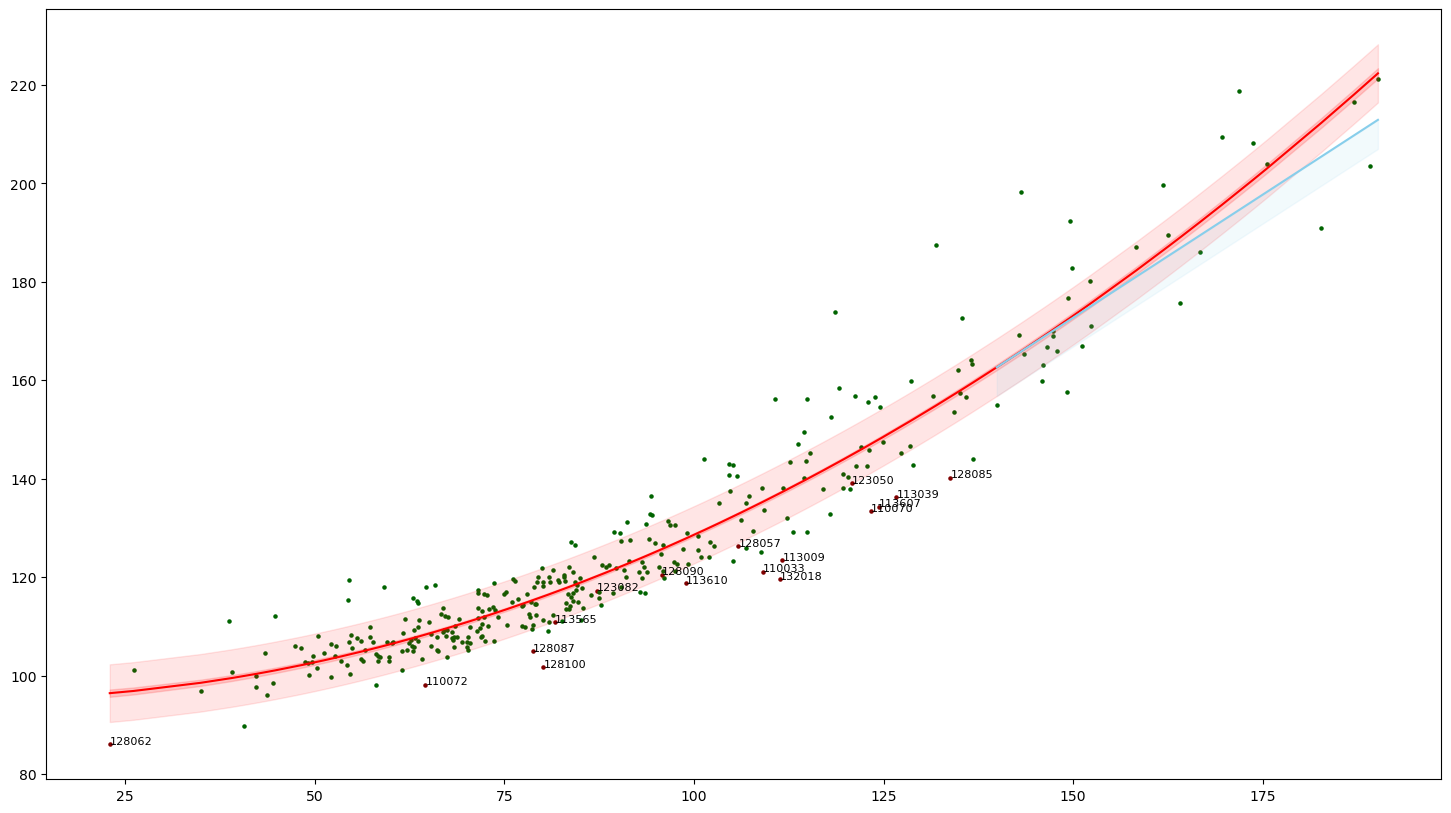

In [36]:
db_df = double_low_arbitrage(data,redeem_df,put_df)
my_df,db_buy_dict = buy_sell_db(db_df,'mycb_list.csv',show_price=True)
lp_df = low_premium_arbitrage(db_df)

In [37]:
lp_df[(lp_df['value'] < 200) & (lp_df['value'] > 180) & (lp_df['price']<200)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
113621,彤程转债,182.711376,190.96,4.514565,195.474565,-4.287488,205.409637,199.514145,211.305128


In [51]:
lp_df.loc['123082']

name                     北陆转债
value               87.195623
price                   117.2
premium             34.410416
db_low             151.051147
lower_deviation      2.484399
fit_price            120.1811
low_fit_price      114.358869
upper_fit_price     126.00333
Name: 123082, dtype: object

In [39]:
buy_sell_low(lp_df,db_buy_dict,'mycb_list.csv',show_price=True)

118002 天合转债 not in lists
Sell 123050 聚飞转债 139.103 154.276 15.173 0.081

Add  132018 G三峡EB1 119.61 127.073 7.463 -8.830
Add  128100 搜特转债 101.688 125.697 26.922 -7.754
Add  128085 鸿达转债 140.2 145.002 4.802 -7.010
Add  110033 国贸转债 121.12 132.185 11.065 -6.428
Add  113585 寿仙转债 143.96 149.204 5.244 -6.324
Add  113009 广汽转债 123.4 133.925 10.525 -6.135

Strong Buy 132018 G三峡EB1 119.61 127.073 7.463 -8.830
Strong Buy 128100 搜特转债 101.688 125.697 26.922 -7.754
Strong Buy 110033 国贸转债 121.12 132.185 11.065 -6.428
Buy 113585 寿仙转债 143.96 149.204 5.244 -6.324
Strong Buy 113009 广汽转债 123.4 133.925 10.525 -6.135
Strong Buy 110070 凌钢转债 133.4 141.565 8.165 -5.527
Strong Buy 113607 伟20转债 134.3 142.261 7.961 -5.518
Strong Buy 113039 嘉泽转债 136.28 143.848 7.568 -5.489
Buy 132014 18中化EB 157.5 163.106 5.606 -5.298
Buy 113595 花王转债 89.82 204.228 120.611 -4.522
Buy 113621 彤程转债 190.96 195.475 4.515 -4.287
Strong Buy 128087 孚日转债 105.0 136.895 33.343 -4.090
Strong Buy 123068 弘信转债 129.25 141.678 12.428 -3.635
Strong Buy 

In [40]:
df2 = lp_df.sort_values('lower_deviation')
df2[0:30]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
132018,G三峡EB1,111.303693,119.610,7.462741,127.072741,-8.829570,137.019935,131.193853,142.846017
128100,搜特转债,80.118543,101.688,26.921928,125.697387,-7.754000,116.058664,110.235674,121.881655
128085,鸿达转债,133.775465,140.200,4.802476,145.002476,-7.010497,156.608328,150.769705,162.446951
110033,国贸转债,109.053252,121.120,11.065005,132.185005,-6.427574,135.265143,129.439842,141.090444
113585,寿仙转债,136.787057,143.960,5.243876,149.203876,-6.323572,159.518891,153.677934,165.359849
113009,广汽转债,111.648555,123.400,10.525389,133.925389,-6.135399,137.292171,131.465962,143.118381
110070,凌钢转债,123.330389,133.400,8.164744,141.564744,-5.527163,147.036331,141.204609,152.868054
113607,伟20转债,124.396334,134.300,7.961381,142.261381,-5.518120,147.975998,142.143657,153.808340
113039,嘉泽转债,126.691831,136.280,7.568103,143.848103,-5.488774,150.028252,144.194512,155.861992


In [41]:
my_df

,name,price,db_low
id,,,
128100,搜特转债,101.688,125.697387
132018,G三峡EB1,119.610,127.072741
110033,国贸转债,121.120,132.185005
113009,广汽转债,123.400,133.925389
128087,孚日转债,105.000,136.894754
113610,灵康转债,118.810,138.698733
110070,凌钢转债,133.400,141.564744
113607,伟20转债,134.300,142.261381
113039,嘉泽转债,136.280,143.848103


today quartile 156.8871223822927


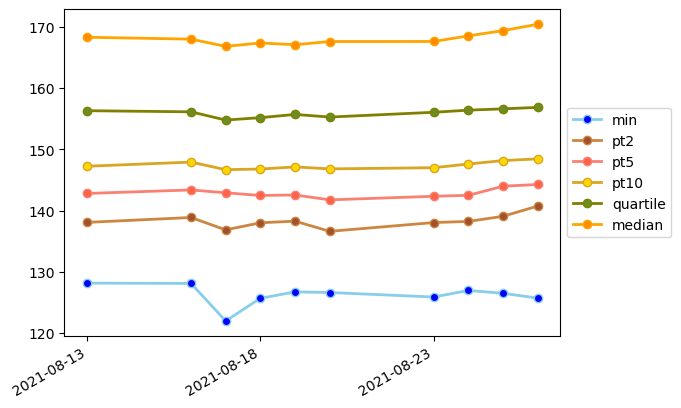

In [42]:
save_historical_data(db_df,'db_low','db_history.csv')
plot_history('db_history.csv')

today quartile 26.026829304783597


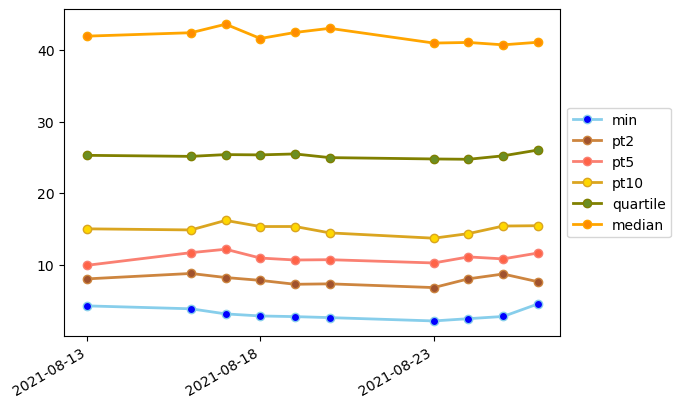

In [43]:
save_historical_data(lp_df,'premium','premium_history.csv')
plot_history('premium_history.csv')

today quartile 109.76


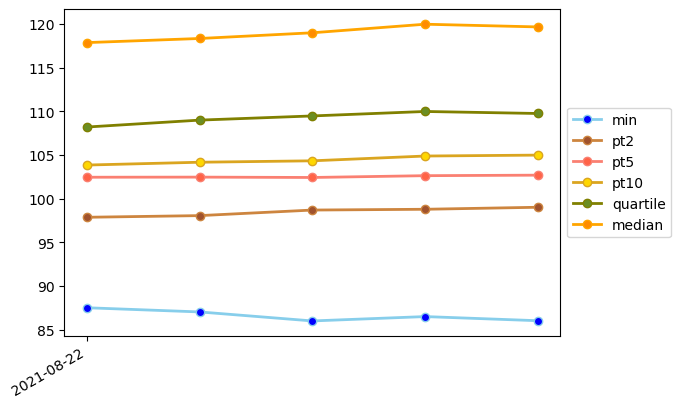

In [44]:
save_historical_data(db_df,'price','price_history.csv')
plot_history('price_history.csv')

In [45]:
db_df[0:10]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,put_convert_price,maturity_dt,redeem_price,last_time,force_redeem,redeem_CAGR,put_CAGR,new_convert_value,new_premium,db_low
id,,,,,,,,,,,,,,,,,,,,,
128100,搜特转债,002503.sz,搜于特,101.688,95.68,6.28%,A,1.38,20.3%,16.7%,...,1.13,2026-03-11,112.000,4.542,X,0.029125,0.002936,80.118543,0.269219,125.697387
132018,G三峡EB1,600900.ss,长江电力,119.610,116.49,2.85%,AAA,2.53,4.0%,4.0%,...,11.72,2024-04-09,108.000,2.622,X,0.000000,0.000000,111.303693,0.074627,127.072741
110033,国贸转债,600755.ss,厦门国贸,121.120,119.05,1.74%,AAA,0.61,7.7%,7.3%,...,4.70,2022-01-05,108.000,0.362,X,0.000000,0.000000,109.053252,0.110650,132.185005
113009,广汽转债,601238.ss,广汽集团,123.400,114.46,7.81%,AAA,1.91,2.2%,1.5%,...,9.78,2022-01-22,106.000,0.408,X,0.000000,0.000000,111.648555,0.105254,133.925389
128087,孚日转债,002083.sz,孚日股份,105.000,91.33,14.96%,AA-,1.01,17.5%,17.4%,...,3.15,2025-12-17,108.000,4.312,X,0.014479,0.000000,78.744468,0.333427,136.894754
113610,灵康转债,603669.ss,灵康药业,118.810,106.27,11.80%,AA-,4.64,7.0%,7.0%,...,6.03,2026-11-30,115.000,5.266,X,0.002281,0.000000,98.912033,0.201168,138.698733
113541,荣晟转债,603165.ss,荣晟环保,125.080,115.13,8.64%,AA-,1.88,5.0%,5.0%,...,7.59,2025-07-22,110.000,3.907,X,0.000000,0.000000,108.863285,0.148964,139.976404
128108,蓝帆转债,002382.sz,蓝帆医疗,123.333,113.93,8.26%,AA,1.65,7.3%,7.3%,...,12.77,2026-05-27,108.000,4.753,N,0.000000,0.000000,105.182119,0.172566,140.589622
128063,未来转债,002631.sz,德尔未来,117.000,103.26,13.31%,AA-,3.32,10.8%,10.6%,...,6.02,2025-04-03,120.000,3.605,X,0.020227,0.000000,92.899746,0.259422,140.919486


In [46]:
db_df[10:20]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,put_convert_price,maturity_dt,redeem_price,last_time,force_redeem,redeem_CAGR,put_CAGR,new_convert_value,new_premium,db_low
id,,,,,,,,,,,,,,,,,,,,,
110070,凌钢转债,600231.ss,凌钢股份,133.400,126.77,5.23%,AA,1.12,2.2%,2.2%,...,1.88,2026-04-12,112.000,4.630,X,0.000000,0.0,123.330389,0.081647,141.564744
123068,弘信转债,300657.sz,弘信电子,129.250,125.81,2.73%,AA-,5.25,7.5%,7.1%,...,10.74,2026-10-14,115.000,5.137,X,0.000000,0.0,114.962432,0.124280,141.678032
123002,国祯转债,300388.sz,节能国祯,111.206,88.76,25.29%,AA,1.39,4.9%,4.9%,...,5.85,2023-11-24,106.000,2.247,X,0.000000,0.0,85.060514,0.307375,141.943512
113607,伟20转债,603568.ss,伟明环保,134.300,129.89,3.39%,AA,6.14,3.4%,3.4%,...,15.20,2026-11-01,110.000,5.186,X,0.000000,0.0,124.396334,0.079614,142.261381
113577,春秋转债,603890.ss,春秋电子,129.070,117.86,9.51%,AA-,2.58,3.6%,3.6%,...,7.60,2026-04-13,112.000,4.633,N,0.000000,0.0,113.062791,0.141578,143.227805
128037,岩土转债,002542.sz,中化岩土,109.000,91.61,18.98%,AA,1.25,14.6%,11.8%,...,2.17,2024-03-15,108.000,2.553,X,0.001992,0.0,80.802603,0.348966,143.697472
113039,嘉泽转债,601619.ss,嘉泽新能,136.280,135.26,0.75%,AA,2.47,5.0%,4.9%,...,2.42,2026-08-23,108.000,4.995,X,0.000000,0.0,126.691831,0.075681,143.848103
123106,正丹转债,300641.sz,正丹股份,125.950,116.13,8.45%,AA-,2.85,7.5%,7.5%,...,5.25,2027-03-23,120.000,5.575,X,0.000000,0.0,106.825745,0.179023,143.852291
113567,君禾转债,603617.ss,君禾股份,114.270,95.97,19.07%,A+,2.95,9.8%,9.8%,...,7.81,2026-03-03,113.000,4.521,X,0.006223,0.0,87.719892,0.302669,143.914613


In [47]:
lp_df[0:20]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
132018,G三峡EB1,111.303693,119.610,7.462741,127.072741,-8.829570,137.019935,131.193853,142.846017
128100,搜特转债,80.118543,101.688,26.921928,125.697387,-7.754000,116.058664,110.235674,121.881655
128085,鸿达转债,133.775465,140.200,4.802476,145.002476,-7.010497,156.608328,150.769705,162.446951
110033,国贸转债,109.053252,121.120,11.065005,132.185005,-6.427574,135.265143,129.439842,141.090444
113585,寿仙转债,136.787057,143.960,5.243876,149.203876,-6.323572,159.518891,153.677934,165.359849
113009,广汽转债,111.648555,123.400,10.525389,133.925389,-6.135399,137.292171,131.465962,143.118381
110070,凌钢转债,123.330389,133.400,8.164744,141.564744,-5.527163,147.036331,141.204609,152.868054
113607,伟20转债,124.396334,134.300,7.961381,142.261381,-5.518120,147.975998,142.143657,153.808340
113039,嘉泽转债,126.691831,136.280,7.568103,143.848103,-5.488774,150.028252,144.194512,155.861992


In [48]:
print(np.percentile(db_df['db_low'],50))
print(np.percentile(db_df['price'],50))
print(np.percentile(lp_df['premium'],50))

170.4866889839564
119.67
41.09118126116884


In [49]:
lp_df[(lp_df['value'] < 30) & (lp_df['price']>70)]

,name,value,price,premium,db_low,lower_deviation,fit_price,low_fit_price,upper_fit_price
id,,,,,,,,,
128062,亚药转债,22.969952,86.036,274.558905,350.108754,-4.993430,96.418410,90.557948,102.278873
132011,17浙报EB,26.129197,101.190,287.267929,386.623582,11.182013,96.869868,91.012923,102.726812


In [98]:
put_df[0:10]

,name,stock_id,stock_name,price,convert_value,premium_rt,rating_cd,pb,convert_amt_ratio,convert_amt_ratio2,...,put_convert_price,maturity_dt,redeem_price,last_time,force_redeem,redeem_dt,force_redeem_price,actual_put_price,CAGR,last_to_put
id,,,,,,,,,,,,,,,,,,,,,
128062,亚药转债,002370.sz,亚太药业,86.036,25.91,232.09%,BB,3.55,49.4%,42.6%,...,11.38,2025-04-02,115.000,3.603,X,None,21.12,102.00,0.104862,1.706849
113595,花王转债,603007.ss,ST花王,89.820,46.53,93.03%,BBB+,0.93,30.7%,30.5%,...,4.84,2026-07-20,116.000,4.901,X,None,9.00,102.64,0.045308,3.010959
113017,吉视转债,601929.ss,吉视传媒,99.650,61.02,63.32%,AA+,0.80,27.8%,27.8%,...,2.06,2023-12-27,106.000,2.337,X,None,3.83,101.04,0.031903,0.441096
128044,岭南转债,002717.sz,岭南股份,98.400,48.90,101.23%,AA-,0.99,20.3%,14.9%,...,4.14,2024-08-14,107.000,2.970,X,None,7.68,101.20,0.026538,1.071233
113576,起步转债,603557.ss,ST起步,96.050,45.88,109.37%,A,1.48,11.1%,11.1%,...,7.38,2026-04-09,115.000,4.622,N,None,13.71,103.04,0.026104,2.726027
113596,城地转债,603887.ss,城地香江,96.810,39.82,143.13%,AA-,1.05,35.1%,27.6%,...,16.98,2026-07-27,108.000,4.921,X,None,31.54,102.48,0.018961,3.030137
113589,天创转债,603608.ss,天创时尚,97.580,47.11,107.13%,AA,1.47,24.1%,24.1%,...,8.60,2026-06-23,110.000,4.827,X,None,15.98,102.48,0.016838,2.934247
128127,文科转债,002775.sz,文科园林,98.109,83.40,17.63%,AA-,0.84,52.3%,45.5%,...,3.42,2026-08-19,115.000,4.984,X,None,6.34,102.64,0.014730,3.087671
110072,广汇转债,600297.ss,广汇汽车,98.160,71.22,37.83%,AA+,0.56,14.5%,14.5%,...,2.82,2026-08-17,110.000,4.978,X,None,5.24,102.00,0.012506,3.087671
